In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import datetime

font = {'family': 'sans-serif', # Helvetica
        'size'   : 12}
matplotlib.rc('font', **font) 
text = {'usetex': False}
matplotlib.rc('text', **text)
monospace_font = {'fontname':'monospace'}


INPUT_FOLDER = 'results'
REFERENCE_ID = 'EPI_ISL_402125'
OUTPUT_FOLDER = 'results'

data_df_all = pd.read_pickle('{}/data_df_with_correction.pkl'.format(INPUT_FOLDER))
data_df_all['date'] = pd.to_datetime(data_df_all['date'])

MAX_DATE = data_df_all['date'].max().date()
FLAG = True
start = datetime.datetime.strptime('2019-12-24', "%Y-%m-%d")
time_list = []
while FLAG:
    end = start + datetime.timedelta(days=7)
    time_list.append((str(start.date()), str(end.date())))
    start = end
    if end.date() > MAX_DATE:
        FLAG = False
        
REFERENCE = (REFERENCE_ID, data_df_all[data_df_all['gisaid_epi_isl'] == REFERENCE_ID]['sequence'].iloc[0])
seq_index = []
index = 0
for base in REFERENCE[1]:
    if base == '-':
        seq_index.append(index)
    else:
        index += 1
        seq_index.append(index)
reference_local_index_map = np.array(seq_index)

def pick_ISM_sites_customized(H_list, positions):
    '''
    pick ISM sites
    '''
    pairs = [(base_idx, H_list[base_idx]) for base_idx in positions]
    position_list = [base_idx for base_idx in positions]
    mapped_reference_index = []
    for index, entropy in pairs:
        mapped_reference_index.append((reference_local_index_map[index], entropy))
    return mapped_reference_index

[H_list, null_freq_list] = pickle.load(open('{}/ENTS_{}_{}.pkl'.format(INPUT_FOLDER, '2019-12-24', time_list[-1][1]), 'rb'))
annotation_df = pd.read_csv('{}/ISM_annotation.txt'.format(INPUT_FOLDER))

en_thres = min(annotation_df['Entropy']) - 0.0001
null_thres = 0.25
tmp = np.where((np.array(H_list) > en_thres) & (null_freq_list < null_thres))[0]
print(tmp.shape[0])
position_list = [base_idx for base_idx in tmp]
ref_position_list = [reference_local_index_map[idx] for idx in position_list]
entropy_pairs = {reference_local_index_map[idx]:H_list[idx] for idx in position_list}

X_en_cul = {}
for start, end in time_list:
    [H_list, null_freq_list] = pickle.load(open('{}/ENTS_{}_{}.pkl'.format(INPUT_FOLDER, '2019-12-24', end), 'rb'))
    mapped_reference_index = pick_ISM_sites_customized(H_list, position_list)
    X_en_cul[('2019-12-24', end)] = mapped_reference_index
    
annotaion_dict  = {}
for i in range(annotation_df.shape[0]):
    annotaion_dict[annotation_df.iloc[i]['Ref position']] = annotation_df.iloc[i]['Gene']

25


In [2]:
T = []
pos_dict_cul = {pos: [] for pos in ref_position_list}
for start, end in time_list:
    T.append(end)
    pos_en = X_en_cul[('2019-12-24', end)]
    for pos, en in pos_en:
        pos_dict_cul[pos].append(en)
import matplotlib.colors as mcolors
CSS4_COLORS = mcolors.CSS4_COLORS
num_colors = len(ref_position_list)

bad_colors = set(['seashell', 'linen', 'ivory', 'oldlace','snow','beige','whitesmoke'
                      'floralwhite', 'lightyellow', 'lightgoldenrodyellow', 'honeydew', 'mintcream', 'azure', 'lightcyan',
                      'aliceblue', 'ghostwhite', 'lavenderblush'
                     ])

by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                             name) for name, color in CSS4_COLORS.items())
names = [name for hsv, name in by_hsv if name not in bad_colors]

ind_list = np.linspace(0, len(names), num_colors, dtype = int, endpoint=False).tolist()
color_names = [names[ind] for ind in ind_list]

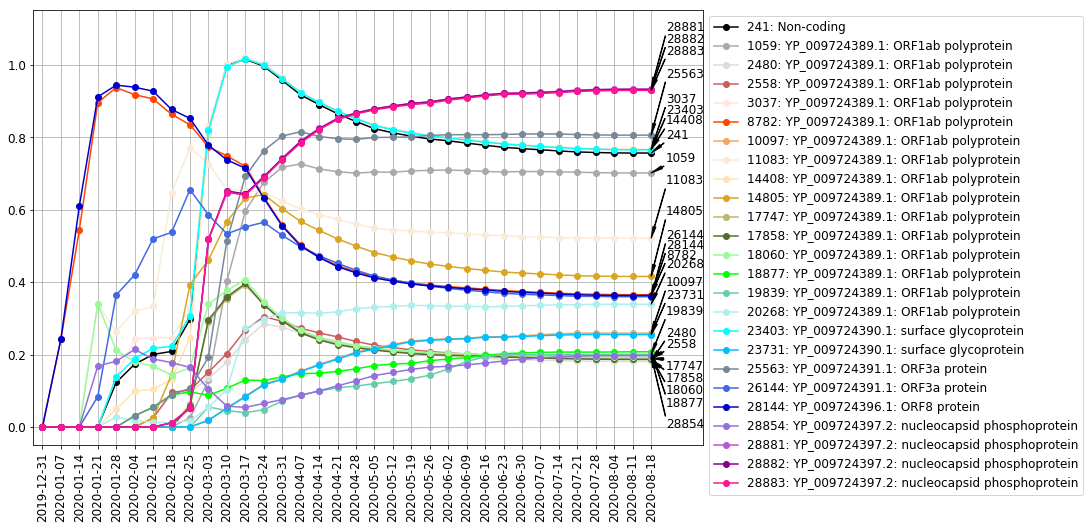

In [12]:
import matplotlib.pyplot as plt
arrow_offset_dict = {
                    28881: (0.8, 0.16), 28882: (0.8, 0.13), 28883: (0.8, 0.1),
                     3037: (0.8, 0.13), 23403: (0.8, 0.10), 14408: (0.8, 0.07),
                      241: (0.8, 0.04), 25563: (0.8, 0.16), 1059: (0.8, 0.03), 
                    14805: (0.8, 0.17), 11083: (0.8, 0.15), 26144: (0.8, 0.16), 
                    28144: (0.8, 0.13),  8782: (0.8, 0.10), 20268: (0.8, 0.10),
                    23731: (0.8, 0.10),10097: (0.8, 0.13),
                    17858: (0.8, -0.06),  18060: (0.8, -0.10), 17747: (0.8, -0.03),
                    2480: (0.8, 0.07), 2558: (0.8, 0.03), 
                    17247: (0.8, -0.12), 25429: (0.8, -0.17), 28854: (0.8, -0.2),
                    25202: (0.8, -0.21), 
                    18877: (0.8, -0.15),
                    19839: (0.8, 0.11)
                    }
fig, ax = plt.subplots(figsize = (12, 8))
for idx, pos in enumerate(ref_position_list):
#     if pos_dict_cul[pos][-1] < 0.3:
#         continue
    plt.plot(np.arange(len(pos_dict_cul[pos])), pos_dict_cul[pos], '-o', color = color_names[idx], label = '{}: {}'.format(pos, annotaion_dict[pos]))
    if idx <=24:
        ax.annotate('{}'.format(pos), xy=(len(T) -1, pos_dict_cul[pos][-1]), 
                    xytext=(len(T) -1 + arrow_offset_dict[pos][0], pos_dict_cul[pos][-1] + arrow_offset_dict[pos][1]),
                arrowprops=dict(facecolor='black', shrink=0, headwidth = 3, width = 0.5),
                )
#     elif idx <= 24:
#         ax.annotate('{}'.format(pos), xy=(len(T) -1, pos_dict_cul[pos][-1]), 
#                     xytext=(len(T) -1 + 0.5, pos_dict_cul[pos][-1] + 0.5),
#                 arrowprops=dict(facecolor='black', shrink=0, headwidth = 3, width = 0.5),
#                 )
plt.xticks(np.arange(len(pos_dict_cul[pos])), T, rotation = 90)
plt.legend(bbox_to_anchor=(1., 1))
plt.xlim([-0.5, len(T) + 1.8])
plt.ylim([-0.05, 1.15])
plt.grid()
plt.savefig('{}/0_Entropy_time_series_analysis.png'.format(OUTPUT_FOLDER), bbox_inches='tight')
plt.show()

In [13]:
import pandas as pd
ISM_df = pd.read_csv('{}/ISM_df_with_correction.csv'.format(INPUT_FOLDER))
# entropy_groups = [(241, 3037, 14408, 23403), (2480, 2558), (8782, 28144),
#                   (10097, 23731), (17747, 17858, 18060), (28881, 28882, 28883)]

entropy_groups = [(241, 3037, 14408, 23403),
                  (28881, 28882, 28883),
                  (1059, 25563),
                  (10097, 18877, 19839, 23731, 28854),
                  (2480, 2558, 17747, 17858, 18060),
                  (8782, 28144)]

pos = annotation_df['Ref position'].tolist()
pos_to_idx = {pos[i]: i for i in range(len(pos))}

In [14]:
res = {'Covarying group': [], 'NT configurations': [], 'Coverage': [],'Representative position': []}
pos_to_rp = {}
for group in entropy_groups:
    x = ISM_df.apply(lambda x, entropy_group=group, 
                      pos_dict=pos_to_idx: ''.join([x['ISM'][pos_dict[pos]] for pos in entropy_group]), 
                      axis = 1)
    res['Covarying group'].append(';'.join([str(item) for item in group]))
    sum_pect = 0
    NT_config = []
    for key, val in x.value_counts()[:2].items():
        sum_pect += val/ISM_df.shape[0]
        NT_config.append(key)
    res['Coverage'].append(sum_pect) 
    res['NT configurations'].append(';'.join(NT_config))
    if 23403 in group:
        RP = 23403
    else:
        RP = sorted([(item, entropy_pairs[item]) for item in group], key=lambda x: x[1], reverse=True)[0][0]
    res['Representative position'].append(RP)
    for base in group:
        pos_to_rp[base] = RP
res = pd.DataFrame.from_dict(res)
res.to_csv('{}/ISM_covary_groups.txt'.format(OUTPUT_FOLDER), index=False)

In [15]:
res

,Covarying group,Coverage,NT configurations,Representative position
0,241;3037;14408;23403,0.965658,TTTG;CCCA,23403
1,28881;28882;28883,0.994064,GGG;AAC,28881
2,1059;25563,0.940333,CG;TT,25563
3,10097;18877;19839;23731;28854,0.903070,GCTCC;ACTTC,10097
4,2480;2558;17747;17858;18060,0.959432,ACCAC;ACTGT,18060
5,8782;28144,0.989312,CT;TC,8782


In [16]:
compressed_list = sorted(set([pos_to_rp[item] if item in pos_to_rp else item for item in pos]))
with open('results/compressed_positions.txt', 'w+') as f:
    f.write(','.join([str(item) for item in compressed_list]))

In [17]:
ISM_df.shape

(75972, 23)

In [6]:
from scipy.spatial import distance
dst = []
idx_to_pos = {pos_to_idx[pos]: pos for pos in pos_to_idx}
for i in range(len(pos_dict_cul)):
    for j in range(i+1, len(pos_dict_cul)):
        dst.append(distance.euclidean(pos_dict_cul[idx_to_pos[i]], pos_dict_cul[idx_to_pos[j]]))

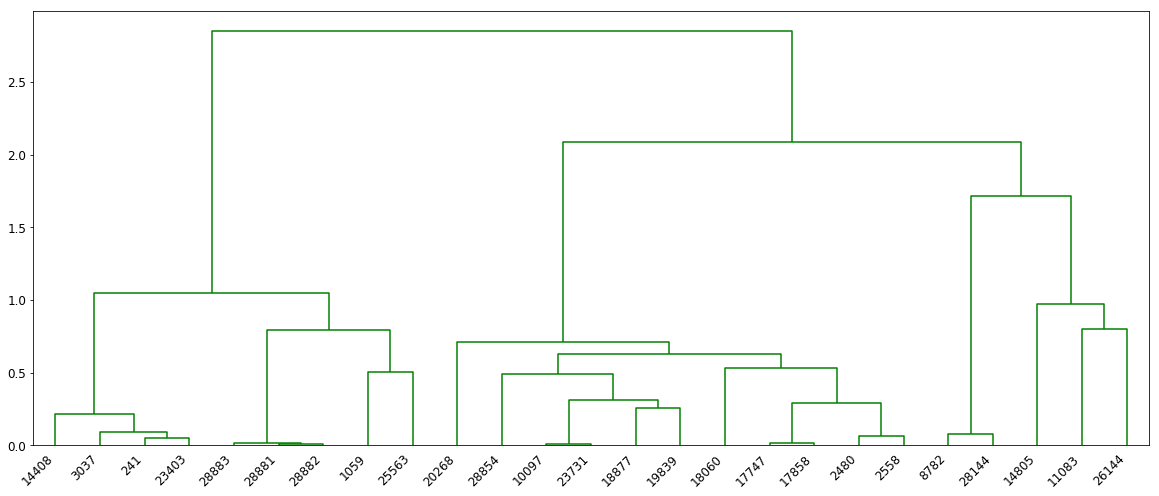

In [7]:
from scipy.cluster.hierarchy import dendrogram, linkage

font = {'family': 'sans-serif',
        'size'   : 12}
matplotlib.rc('font', **font) 

linked = linkage(dst, 'average')

fig, ax = plt.subplots(figsize=(20,8))
dendrogram(linked,
            orientation='top',
            labels=[idx_to_pos[idx] for idx in range(len(pos_dict_cul))],
            distance_sort='descending',
            color_threshold=3,
            leaf_font_size=12,
            show_leaf_counts=True)
plt.setp(ax.get_xticklabels(), ha='right', rotation=45)
# plt.savefig('{}/4_top_ISM_tree.pdf'.format(output_folder), bbox_inches='tight')
plt.show()

In [8]:
from scipy.cluster.hierarchy import fcluster
clustering = fcluster(linked, t=0.6, criterion='distance')

In [9]:
db_groups = {}
for cluster_id in np.unique(clustering):
    if np.where(clustering == cluster_id)[0].shape[0] == 1:
        continue
    db_groups[cluster_id] = []
    for idx in np.where(clustering == cluster_id)[0]:
        db_groups[cluster_id].append(idx_to_pos[idx])

In [10]:
entropy_groups = [tuple(db_groups[item]) for item in db_groups]

In [11]:
entropy_groups

[(241, 3037, 14408, 23403),
 (28881, 28882, 28883),
 (1059, 25563),
 (10097, 18877, 19839, 23731, 28854),
 (2480, 2558, 17747, 17858, 18060),
 (8782, 28144)]

In [11]:
# ISM_df['ISM_compressed'] = ISM_df.apply(lambda x, compressed_list=compressed_list, 
#                       pos_dict=pos_to_idx: ''.join([x['ISM'][pos_dict[pos]] for pos in compressed_list]), 
#                       axis = 1)
# ISM_df.to_csv('{}/ISM_df_compressed.csv'.format(OUTPUT_FOLDER), index=False)